## Deep Hedging vs Delta Hedging — 1D European Call under Black-Scholes


We compare deep hedging with classical delta hedging on a 1D European call option under the Black-Scholes model.

The goal is to check whether the deep hedging implementation correctly recovers the option price and hedge when trained on simulated paths.

In [1]:
import torch
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
sys.path.append(str(Path().resolve().parents[0] / "src"))
from models.BS import BS
from DataGenerator import DataGenerator
from Trainer import Trainer
from Environment import Env, MarketEnv, TrainingEnv
from HedgeModel import HedgeModel
from PnL import PnL
import math

from scipy import stats

We consider:
- Initial price $S_0 = 100$
- Strike $K = 100$
- Maturity $T = 1$
- Volatility $\sigma = 0.4$
- Risk-free rate $r = 0.03$
- Rehedging at $N = 11$ discrete times

Payoff: $f(S_T) = \max(S_T - K, 0)$


We assume the option is sold at time 0 at price $p_0$.

The hedger adjusts their position $\phi_n$ in the underlying at each time step $t_n$.

The P&L (Profit and Loss) is:
$$
\text{P\&L} = p_0 - \sum_{n=0}^{N-1} \phi_n (S_{t_{n+1}} - S_{t_n}) - f(S_{T_N})
$$

In continuous time, delta hedging gives zero P&L. In discrete time, the PnL has non-zero variance.


We use a feedforward neural network (3 layers of 32 neurons) to learn the hedging strategy.

The network is trained to minimise the second moment of the terminal P&L:
$$
\mathbb{E}\left[\text{P\&L}^2\right]
$$

This gives both the option price $p_0$ (through training) and the hedging strategy $\hat{\phi}_\theta$.


#### Training

In [2]:
K = 100
payoff_func = lambda x: torch.nn.functional.relu(x - K)
market_env = MarketEnv(S0 = 100, T = 1, N = 11, r = 0.03, sigma = 0.4, payoff_func = payoff_func, tc = 0.0, scaling_factor = 200)
market_env.K = K


hedging_nn = HedgeModel(N = market_env.N, d = 1, layer_sizes = [32,32,32], T = 1)
training_env = TrainingEnv(model = hedging_nn ,batch_size = 2**12, lr_p0 = 0.05, lr_rest = 1e-3, device = "mps")
env = Env(market_env = market_env, training_env = training_env)

bs = BS(r=market_env.r, sigma=market_env.sigma)

data_generator = DataGenerator(model = bs, env = env)

pnl_calc = PnL(market_env = market_env)

risk_measure = lambda x: (x**2).mean() 


trainer = Trainer(model = training_env.model, env = env, data_generator = data_generator, pnl_calc = pnl_calc, risk_measure = risk_measure)

losses = trainer.train(128)

Training: 100%|████████████████████| 128/128 [00:24<00:00,  5.23it/s, loss=71.5]


#### Evaluation

To evaluate performance, we generate new test paths under the Black-Scholes model.

This out-of-sample evaluation allows us to compare the learned strategy to the theoretical delta hedge.

In [3]:
discounted_path, discounted_payoff = data_generator.generate_batch(2**15)

In [4]:
Norm = torch.distributions.normal.Normal(0,1)

def bs_delta_hedge(market_env,K,n,x):
    if n == 0:
        return bs_price(x, K, market_env.r , market_env.sigma, market_env.T), bs_delta(x, K, market_env.r , market_env.sigma, market_env.T)
    else:
        return bs_delta(x, K, market_env.r , market_env.sigma, market_env.T*(market_env.N-n)/market_env.N)

def bs_price(S0, K, r, sigma, T):
    d1 = (torch.log(S0/K) + (r+sigma**2/2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*Norm.cdf(d1) - K*np.exp(-r*T)*Norm.cdf(d2)

def bs_delta(S0, K, r, sigma, T):
    d1 = (torch.log(S0/K) + (r+sigma**2/2)*T)/(sigma*math.sqrt(T))
    return Norm.cdf(d1)


def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result



In [5]:
pnl = pnl_calc.compute_pnl(discounted_path, discounted_payoff, hedging_nn)
pnl_np = pnl.detach().cpu().numpy()
bs_pnl = pnl_calc.compute_pnl(discounted_path, discounted_payoff, lambda n,x: bs_delta_hedge(market_env,market_env.K/market_env.scaling_factor,n,x))
bs_pnl_np = bs_pnl.detach().cpu().numpy()

In [6]:
print("NN",monte_carlo(pnl_np[:,0]))
print("Delta hedge",monte_carlo(bs_pnl_np[:,0]))

NN {'mean': np.float32(-0.15628669), 'var': np.float32(70.217384), 'lower': np.float64(-0.24701554233522754), 'upper': np.float64(-0.06555783098249095)}
Delta hedge {'mean': np.float32(0.18450177), 'var': np.float32(18.675417), 'lower': np.float64(0.13771120481829202), 'upper': np.float64(0.23129232949872458)}


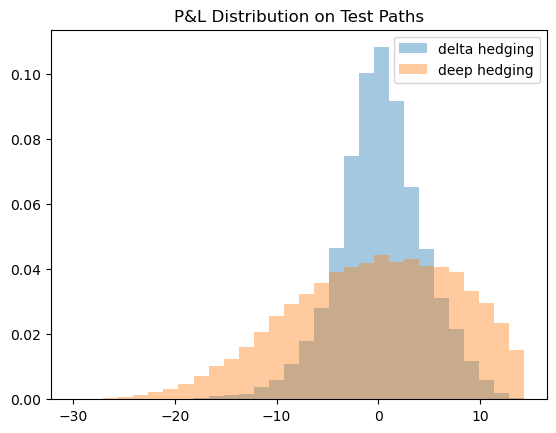

In [7]:
_, bins = np.histogram(bs_pnl_np, bins=30)
fig, ax = plt.subplots()
ax.hist(bs_pnl_np, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax.hist(pnl_np, bins=bins, density=True, alpha=0.4, label="deep hedging")
ax.legend()
plt.title("P&L Distribution on Test Paths")
plt.show()

The neural network already learns a reasonable hedge: the P&L distribution is concentrated and close to zero on average.

However, compared to delta hedging, the variance is higher and the distribution is slightly shifted.  
This suggests the strategy is not fully optimal yet.


In [8]:
hedging_nn.p0 * market_env.scaling_factor

tensor([16.7619], grad_fn=<MulBackward0>)

In [9]:
bs_price(S0=torch.tensor(market_env.S0), K=market_env.K, r=market_env.r, sigma=market_env.sigma, T=market_env.T)

tensor(17.1387)

The neural network also recovers a price close to the Black-Scholes formula, which confirms that the optimisation correctly identifies both the hedge and the option value.


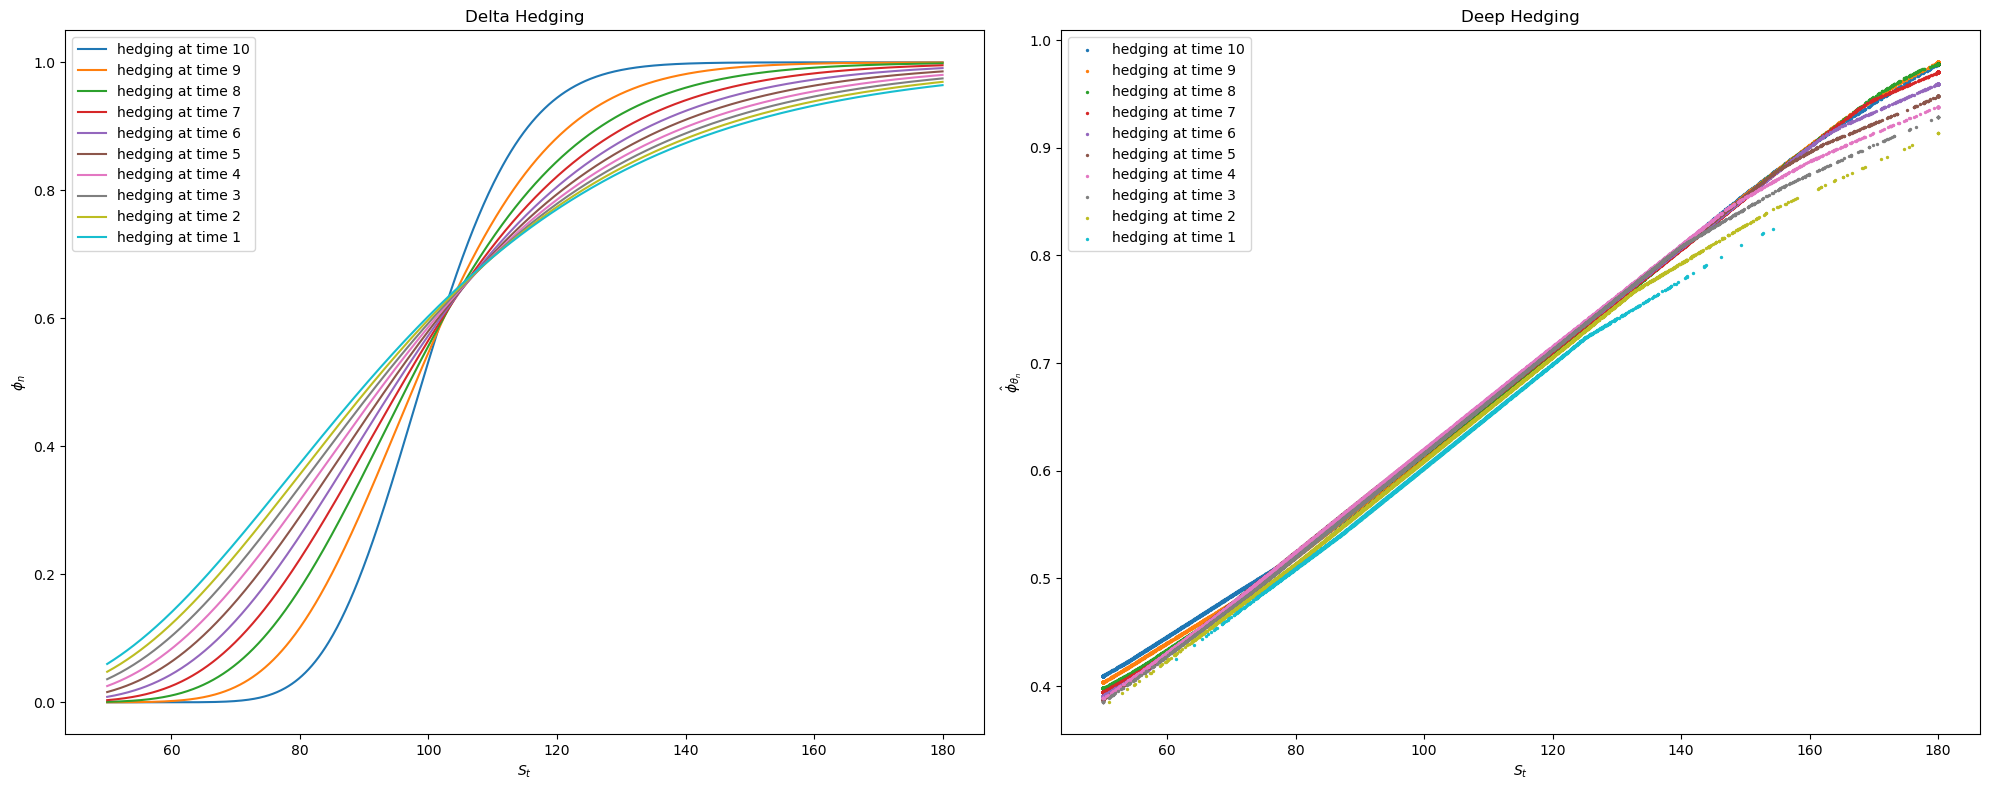

In [10]:
xx = np.linspace(50, 180, 1000)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))
for n in reversed(range(1, market_env.N)):
    with torch.no_grad():
        ax1.plot(xx, bs_delta(torch.tensor(xx), market_env.K,market_env.r,market_env.sigma, (market_env.N-n)*market_env.T/market_env.N), label=f"hedging at time {n}")
        ax2.scatter(torch.clamp(discounted_path[:5000,n,:]*market_env.scaling_factor,50,180), hedging_nn(n,torch.clamp(discounted_path[:5000,n,:],50/market_env.scaling_factor,180/market_env.scaling_factor)), s=2, label=f"hedging at time {n}")
ax1.set_title("Delta Hedging")
ax2.set_title("Deep Hedging")
ax1.legend()
ax2.legend()
ax1.set_xlabel("$S_t$")
ax2.set_xlabel("$S_t$")
ax1.set_ylabel(r"$\phi_n$")
ax2.set_ylabel(r"$\hat{\phi}_{\theta_n}$")

plt.tight_layout()
plt.show()

Left: theoretical Black-Scholes deltas $\Delta(S_t, t)$  
Right: learned hedges $\hat{\phi}_\theta(t, S_t)$ on test paths

The learned hedge has the right order of magnitude but does not yet capture the correct shape.  


#### More training

In [11]:
losses = trainer.train(256)

Training: 100%|████████████████████| 256/256 [00:52<00:00,  4.90it/s, loss=20.3]


In [12]:
pnl = pnl_calc.compute_pnl(discounted_path, discounted_payoff, hedging_nn)
pnl_np = pnl.detach().cpu().numpy()
bs_pnl = pnl_calc.compute_pnl(discounted_path, discounted_payoff, lambda n,x: bs_delta_hedge(market_env,market_env.K/market_env.scaling_factor,n,x))
bs_pnl_np = bs_pnl.detach().cpu().numpy()

In [13]:
print("NN",monte_carlo(pnl_np[:,0]))
print("Delta hedge",monte_carlo(bs_pnl_np[:,0]))
print(hedging_nn.p0 * market_env.scaling_factor)

NN {'mean': np.float32(0.04948719), 'var': np.float32(20.925573), 'lower': np.float64(-4.20690672602933e-05), 'upper': np.float64(0.09901644598414566)}
Delta hedge {'mean': np.float32(0.18450177), 'var': np.float32(18.675417), 'lower': np.float64(0.13771120481829202), 'upper': np.float64(0.23129232949872458)}
tensor([16.9891], grad_fn=<MulBackward0>)


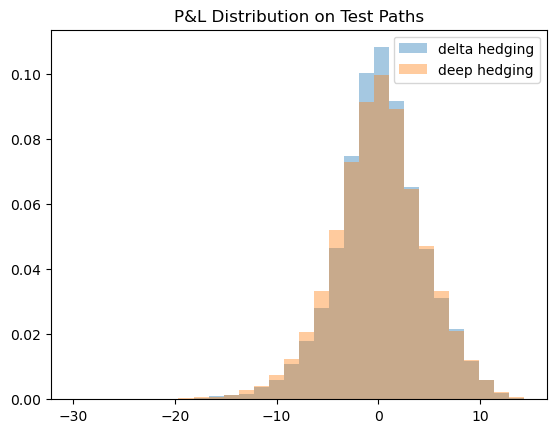

In [14]:
_, bins = np.histogram(bs_pnl_np, bins=30)
fig, ax = plt.subplots()
ax.hist(bs_pnl_np, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax.hist(pnl_np, bins=bins, density=True, alpha=0.4, label="deep hedging")
ax.legend()
plt.title("P&L Distribution on Test Paths")
plt.show()

After a second training phase, the neural network's P&L distribution is now very close to the delta hedge.

The variance is comparable and the distribution is well centred.  
This confirms that the network has learned both the correct option price and an accurate hedge.


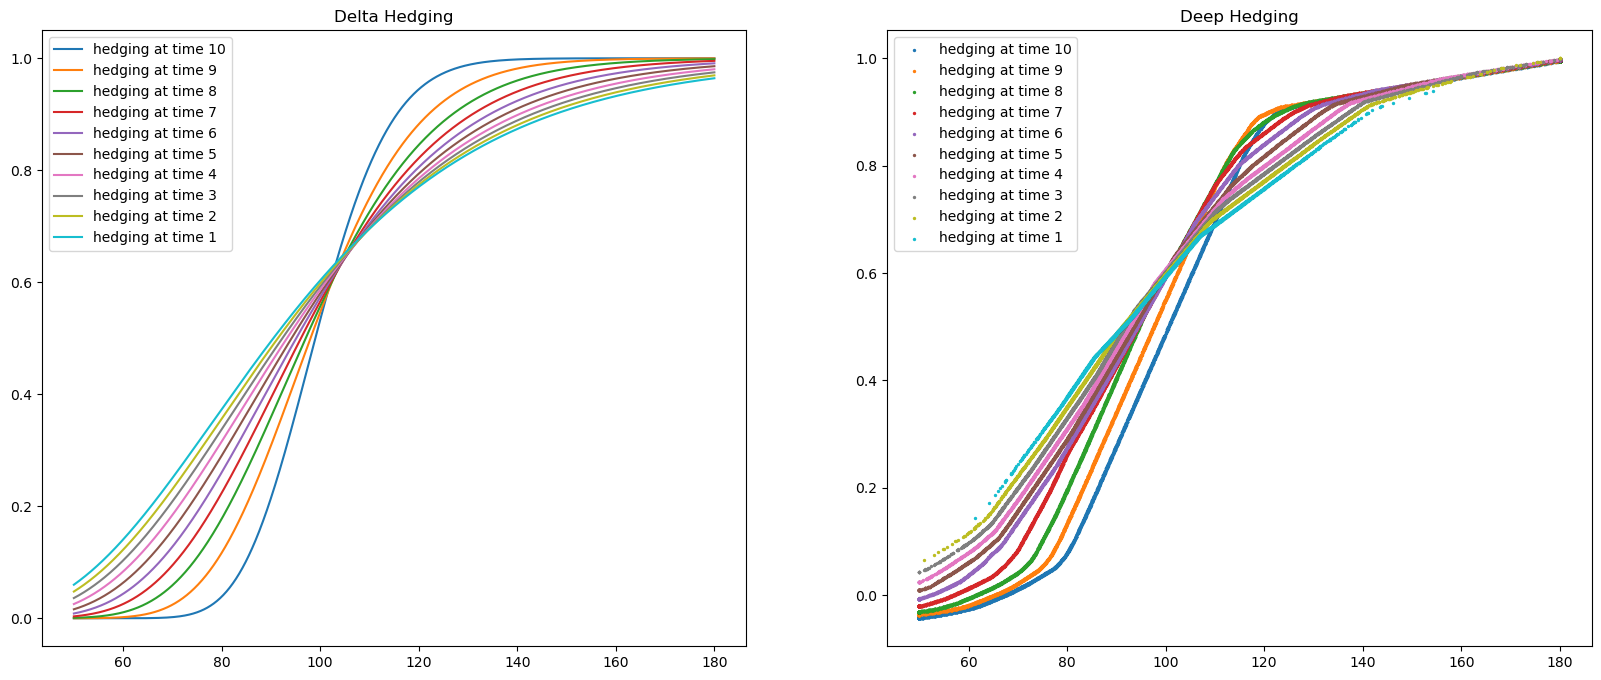

In [15]:
xx = np.linspace(50, 180, 1000)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))
for n in reversed(range(1, market_env.N)):
    with torch.no_grad():
        ax1.plot(xx, bs_delta(torch.tensor(xx), market_env.K, market_env.r,market_env.sigma, (market_env.N-n)*market_env.T/market_env.N), label=f"hedging at time {n}")
        ax2.scatter(torch.clamp(discounted_path[:5000,n,:]*market_env.scaling_factor,50,180), hedging_nn(n,torch.clamp(discounted_path[:5000,n,:],50/market_env.scaling_factor,180/market_env.scaling_factor)), s=2, label=f"hedging at time {n}")
ax1.set_title("Delta Hedging")
ax2.set_title("Deep Hedging")
ax1.legend()
ax2.legend()
plt.show()

The learned hedge shows a similar shape to the delta hedge, with better alignment than after the first training.

Some irregularities remain, but the overall behaviour is consistent with the improved P&L.


#### Conclusion

The neural network is trained to minimise the second moment of the hedging P&L for a 1D European call under the Black-Scholes model.

After sufficient training, it recovers a strategy that matches the P&L distribution of the delta hedge and produces a price close to the theoretical one.

The hedge functions also show similar behaviour, despite not using any model information.
